# Cumulative event counter

### This notebook counts the cumulative spatio-temporal distribution of cellular events in the local neighbourhood of a series of apoptosis events

1. Load dictionary of apoptoses and their corresponding times to base the spatiotemporal scans around 
2. Load corresponding tracking data and specify scan parameters
3. Iteratively calculate spatiotemporal distribution of cellular events around apoptoses, saving each distribution out as a .npy distance-time heatmap
4. Compile list of spatiotemporal heatmaps as cumulative heatmap
5. Misc. section: comparing different experimental conditions

In [74]:
import calculate_radial_analysis as calculate
import tools
import render

import json
import glob
import os
import re
import numpy as np
from natsort import natsorted
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

## 1) Apoptosis dictionary loader
Specify cell type to filter out unwanted apoptoses, want end result of apop_dict that takes the format of :`apop_dict = {apop_ID:apop_time}` 

where `apop_ID` takes the format of: `GV{experiment_ID}_Pos{position_ID}_{cell_ID}_{cell_type}` 

For example: 

```
apop_dict = {'GV0794_Pos4_393_GFP': '766',
             'GV0794_Pos7_364_GFP': '550',
             'GV0794_Pos7_457_GFP': '805',
             'GV0794_Pos7_369_GFP': '833',
             'GV0794_Pos7_292_GFP': '884',
             'GV0795_Pos4_358_GFP': '628',
             'GV0795_Pos4_18_GFP': '855',
             'GV0795_Pos4_1356_GFP': '992',
             'GV0795_Pos4_359_GFP': '1133',
             'GV0796_Pos4_542_GFP': '581',
             'GV0796_Pos4_1334_GFP': '719',
             'GV0796_Pos4_1586_GFP': '785'}
 ```

In [244]:
if focal_cell == 'Scr':
    cell_type = 'RFP'
if focal_cell == 'WT':
    cell_type = 'GFP '## ie the cell type to base the analysis around, the central cell around which you want to observe the other cell type behaviours

path_to_apop_lists = '/media/nathan/Transcend/Nathan/data/h2b/apoptosis_information/final/all'
expts_apop_lists = os.listdir(path_to_apop_lists)
apop_dict = {}
N_apops = len(expts_apop_lists)
for expt_apop_list in expts_apop_lists:
    apop_list = open(os.path.join(path_to_apop_lists, expt_apop_list), 'r')
    for apop_ID in apop_list:
        if cell_type in apop_ID:
            if 'stitched' not in apop_ID: ## relic of apoptosis finding (stitched = tracks that apoptosis switches into post apop)
                apop_dict[apop_ID.split()[0]] = apop_ID.split()[1]
orig_len_apops = len(apop_dict)
apop_dict

{'GV0804_Pos4_179_RFP': '625',
 'GV0804_Pos4_249_RFP': '850',
 'GV0804_Pos4_110_RFP': '851',
 'GV0804_Pos4_292_RFP': '902',
 'GV0804_Pos4_342_RFP': '999',
 'GV0804_Pos4_343_RFP': '1002',
 'GV0804_Pos4_231_RFP': '1010',
 'GV0804_Pos4_339_RFP': '1009',
 'GV0804_Pos4_333_RFP': '1014',
 'GV0804_Pos4_353_RFP': '1050',
 'GV0804_Pos4_351_RFP': '1084',
 'GV0804_Pos4_163_RFP': '1074',
 'GV0804_Pos4_217_RFP': '1142',
 'GV0794_Pos4_6_RFP': '469',
 'GV0794_Pos4_73_RFP': '773',
 'GV0794_Pos4_70_RFP': '820',
 'GV0794_Pos7_52_RFP': '195',
 'GV0794_Pos7_192_RFP': '258',
 'GV0794_Pos7_352_RFP': '749',
 'GV0794_Pos7_328_RFP': '827',
 'GV0794_Pos7_329_RFP': '846',
 'GV0794_Pos7_360_RFP': '874',
 'GV0794_Pos7_429_RFP': '889',
 'GV0795_Pos4_1_RFP': '6',
 'GV0795_Pos4_7_RFP': '8',
 'GV0795_Pos4_103_RFP': '472',
 'GV0795_Pos4_284_RFP': '639',
 'GV0795_Pos4_235_RFP': '642',
 'GV0795_Pos4_234_RFP': '671',
 'GV0795_Pos4_285_RFP': '654',
 'GV0795_Pos4_223_RFP': '418',
 'GV0795_Pos4_323_RFP': '956',
 'GV0795_Pos4

In [76]:
### parallelisation 
N_apops = len(apop_dict)
para_frac_min, para_frac_max = int(0*N_apops), int(0.25*N_apops)  ## ie only do first 1/4 of all apops
delete_list =[]
for i, j in enumerate(apop_dict):
    if not para_frac_min <= i< para_frac_max: 
        delete_list.append(j)
for i in delete_list:
    del apop_dict[i]
print("Length of modified dict vs original:", len(apop_dict), "/", orig_len_apops)

Length of modified dict vs original: 459 / 1839


## 2) Load corresponding cell tracking data and specifiy other parameters

In [77]:
### load tracking data
path_to_hdf5 = '/media/nathan/Transcend/Nathan/data/h2b'
hdf5_file_list = tools.hdf5_file_finder(path_to_hdf5)

### specify output path and neighbourhood scan parameters
output_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/individual_spatiotemporal_heatmaps/scr_apop_wt_div'
Path(output_path).mkdir(parents=True, exist_ok=True)
radius, t_range, num_bins = 400, 400, 10#800, 800, 20#400, 400, 10


## 3) Iteratively calculate and save out individual heatmaps

This step can be time consuming (sequential scans around 385 apoptoses took 7 hours on i7)

Function to calculate:

`calculate.iterative_heatmap_generator(subject_cells = 'WT', subject_event = 'DIVIDE', apop_dict, hdf5_file_list, radius, t_range, num_bins, output_path)`

Where the necessary input variables are as follows:
- `subject_cells` = The population of cells to scan over looking for events, 'WT'/'Scr'/'All'
- `subject_event` = The event type to look for, 'DIVIDE' or 'APOPTOSIS'
- `apop_dict` = Previously defined python dictionary of {apoptosis ID: apoptosis time}
- `hdf5_file_list` = List of locations of tracking files
- `radius` = Distance to scan over around apoptosis
- `t_range` = Time range to scan over around apoptosis (will scan t_range/2 before and after apoptosis)
- `num_bins` = Number of bins the histogram is sorted into
- `output_path` = Empty directory to save out individual apoptosis heatmap .npy arrays into


In [ ]:
N_cells, error_log, success_log = calculate.iterative_heatmap_generator(
    'WT', ## 'Scr',
    'DIVIDE', 
    apop_dict, 
    hdf5_file_list, 
    radius, 
    t_range, 
    num_bins, 
    output_path)

In [ ]:
N_cells ## scope of analysis (number of apoptoses scanned around)

In [ ]:
len(error_log)

In [ ]:
error_log, success_log

## 4) Compile individual heatmaps into cumulative plots 

Compile cumulative heatmap by iteratively adding single-apoptosis heatmaps from previous output or different pre-established output 

In [161]:
#single_cell_heatmap_location = output_path
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/individual_spatiotemporal_heatmaps/800,20/wt_apop_scr_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div'
Path(save_path).mkdir(parents=True, exist_ok=True)
radius, t_range, num_bins = 800, 800, 20#400, 400, 10

In [174]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    if 'N_cells' in heatmap_ID:
        N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
    if 'N_events' in heatmap_ID:
        N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        N+=1
N

385

In [130]:
print("The number of scr. cells counted is equal to = ", N_cells.sum())

The number of scr. cells counted is equal to =  6537536.0


Function to plot heatmaps: 

`plot_cumulative(input_2d_hist, num_bins, radius, t_range, title, expt_label, cb_label, save_path, SI = True)`

Where the variables needed are as follows:

- `input_2d_hist` = Input 2D histogram
- `num_bins` = Number of bins the histogram is sorted into
- `radius` = Spatial extent of scan
- `t_range` = Temporal range of scan
- `title` = Title/save out filename of heatmap
- `label` = Optional label for heatmap
- `cb_label` = Label for colourbar
- `save_path` = Ouput save path, if empty string then plot will not be saved out
- `SI` = If True then plots the xy in SI base unit instead of pixel/frames

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div/Spatiotemporal dist. of Scribble cells 
 around wild-type apoptoses (N=385).pdf


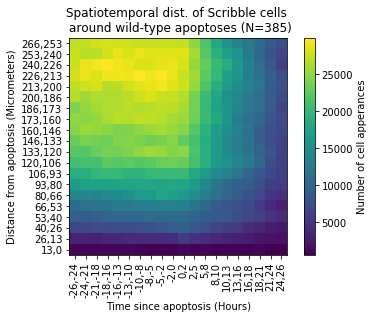

In [109]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of Scribble cells \n around wild-type apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div/Spatiotemporal dist. of Scribble mitoses 
 around wild-type apoptoses (N=385).pdf


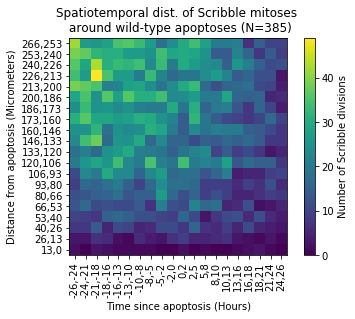

In [110]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of Scribble mitoses \n around wild-type apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Number of Scribble divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div/Spatiotemporal dist. of probability of Scribble division 
 around wild-type apoptoses (N=385).pdf


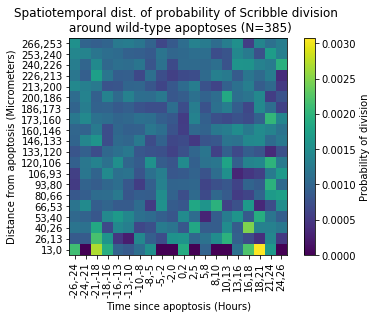

In [111]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of probability of Scribble division \n around wild-type apoptoses (N={})'.format(N), 
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/wt_apop_scr_div',
                SI = True)

# 5) Miscellaneous section: segregating cumulative plots based on experiment type

50:50 expt

In [146]:
single_cell_heatmap_location = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/individual_spatiotemporal_heatmaps/800,20/scr_apop_wt_div'
save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types'
Path(save_path).mkdir(parents=True, exist_ok=True)

In [117]:
expt_list_5050 = ['GV0794/Pos4',
                 'GV0794/Pos7',
                 'GV0794/Pos16',
                 'GV0795/Pos4',
                 'GV0795/Pos7',
                 'GV0795/Pos17',
                 'GV0796/Pos4',
                 'GV0796/Pos7',
                 'GV0796/Pos21',
                 'GV0796/Pos22',
                 'GV0797/Pos4',
                 'GV0797/Pos7',
                 'GV0797/Pos20',
                 'GV0797/Pos21',
                 'GV0798/Pos4',
                 'GV0798/Pos7',
                 'GV0798/Pos20',
                 'GV0798/Pos21',
                 'GV0800/Pos4', 
                 'GV0800/Pos7',
                 'GV0800/Pos16',
                 'GV0801/Pos4',
                 'GV0802/Pos4',
                 'GV0804/Pos4',
                 'GV0805/Pos4',
                 'GV0806/Pos4',
                 'GV0807/Pos4',
                 'GV0812/Pos0',
                 'GV0812/Pos1',
                 'GV0812/Pos2',
                 'GV0812/Pos3',
                 'GV0812/Pos4',
                 'GV0812/Pos5',
                 'GV0813/Pos0',
                 'GV0813/Pos1',
                 'GV0813/Pos2',
                 'GV0813/Pos3',
                 'GV0813/Pos4',
                 'GV0813/Pos5',
                 'GV0814/Pos0',
                 'GV0814/Pos11',
                 'GV0814/Pos12',
                 'GV0814/Pos23',
                 'GV0815/Pos0',
                 'GV0815/Pos11',
                 'GV0815/Pos12',
                 'GV0815/Pos23',
                 'GV0816/Pos0',
                 'GV0816/Pos13',
                 'GV0816/Pos14',
                 'GV0816/Pos23',
                 'GV0817/Pos0',
                 'GV0817/Pos11',
                 'GV0817/Pos12',
                 'GV0817/Pos23',
                 'GV0818/Pos12',
                 'GV0818/Pos13',
                 'GV0819/Pos0',
                 'GV0819/Pos1',
                 'GV0819/Pos2',
                 'GV0819/Pos3',
                 'GV0819/Pos4',
                 'GV0819/Pos5',
                 'GV0820/Pos0',
                 'GV0820/Pos1',
                 'GV0820/Pos2',
                 'GV0820/Pos3',
                 'GV0820/Pos4',
                 'GV0820/Pos5']

In [147]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N = 0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_5050:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

1111

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=1111, 50:50 wt:scr expts only).pdf


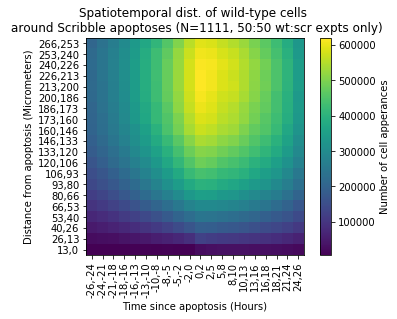

In [148]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division 
 around Scribble apoptoses (N=1111, 50:50 wt:scr expts only).pdf


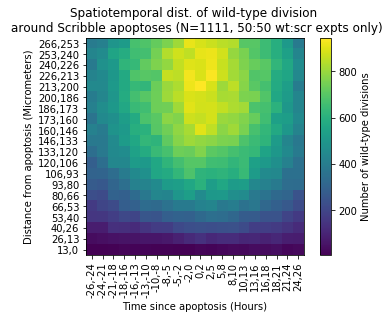

In [149]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of Scribble division 
 around wild-type apoptoses (N=1111, 50:50 wt:scr expts only).pdf


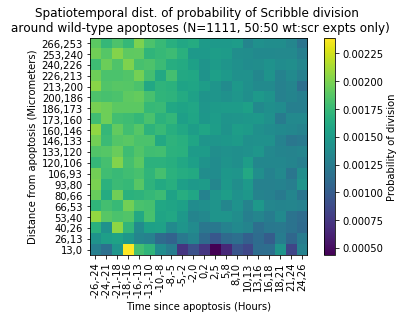

In [150]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800,  
                title = 'Spatiotemporal dist. of probability of Scribble division \n around wild-type apoptoses (N={}, 50:50 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True)

90:10 wt:scr

In [96]:
expt_list_9010 = ['GV0794/Pos3',
 'GV0794/Pos8',
 'GV0794/Pos15',
 'GV0795/Pos3',
 'GV0795/Pos8',
 'GV0795/Pos16',
 'GV0796/Pos3',
 'GV0796/Pos8',
 'GV0796/Pos19',
 'GV0796/Pos20',
 'GV0797/Pos3',
 'GV0797/Pos8',
 'GV0797/Pos18',
 'GV0797/Pos19',
 'GV0798/Pos3',
 'GV0798/Pos8',
 'GV0798/Pos18',
 'GV0798/Pos19',
 'GV0800/Pos3',
 'GV0800/Pos8',
 'GV0800/Pos15',
 'GV0801/Pos3',
 'GV0802/Pos3',
 'GV0804/Pos3',
 'GV0805/Pos3',
 'GV0806/Pos3',
 'GV0807/Pos3']

In [151]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_9010:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

131

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


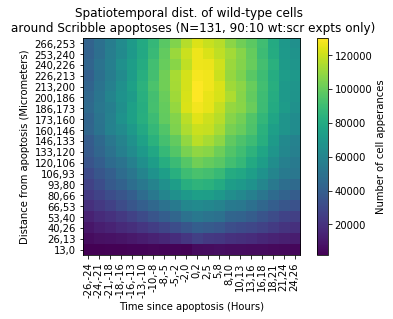

In [152]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of wild-type cells \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


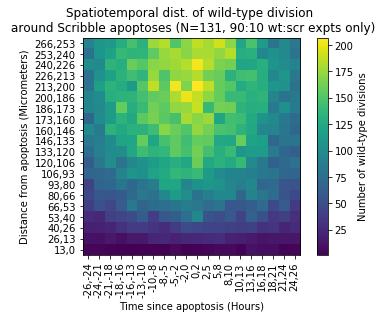

In [153]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of wild-type division 
 around Scribble apoptoses (N=131, 90:10 wt:scr expts only).pdf


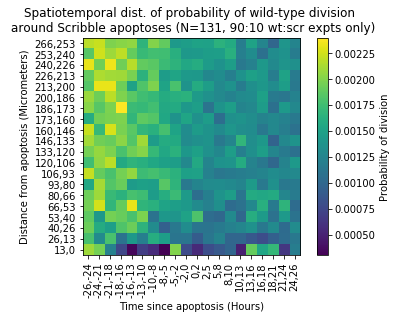

In [155]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of probability of wild-type division \n around Scribble apoptoses (N={}, 90:10 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True)

10:90 wt:scr

In [101]:
expt_list_1090 = ['GV0794/Pos5',
 'GV0794/Pos6',
 'GV0795/Pos5',
 'GV0795/Pos6',
 'GV0795/Pos18',
 'GV0796/Pos5',
 'GV0796/Pos6',
 'GV0796/Pos23',
 'GV0796/Pos24',
 'GV0797/Pos5',
 'GV0797/Pos6',
 'GV0797/Pos22',
 'GV0797/Pos23',
 'GV0798/Pos5',
 'GV0798/Pos6',
 'GV0798/Pos22',
 'GV0798/Pos23',
 'GV0800/Pos5',
 'GV0800/Pos6',
 'GV0800/Pos17',
 'GV0801/Pos5',
 'GV0802/Pos5',
 'GV0804/Pos5',
 'GV0805/Pos5',
 'GV0806/Pos5',
 'GV0807/Pos5']

In [156]:
N_cells, N_events = np.zeros((num_bins, num_bins)), np.zeros((num_bins, num_bins))
N=0
for heatmap_ID in natsorted(os.listdir(single_cell_heatmap_location)):
    #print(heatmap_ID.split('_P'))
    expt = 'GV' +str(re.findall(r"GV(\d+)", heatmap_ID)[0])
    position = re.findall(r"Pos(\d+)", heatmap_ID)[0]
    if os.path.join(expt,'Pos'+position) in expt_list_1090:
        if 'N_cells' in heatmap_ID:
            N_cells += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
        if 'N_events' in heatmap_ID:
            N_events += np.load(os.path.join(single_cell_heatmap_location,heatmap_ID))
            N+=1
N

597

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type cells around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


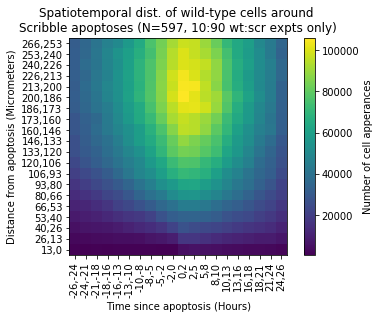

In [157]:
render.plot_cumulative(input_2d_hist = N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of wild-type cells around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N), 
                label = '', 
                cb_label = 'Number of cell apperances', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True) ## SI is standard 

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of wild-type division around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


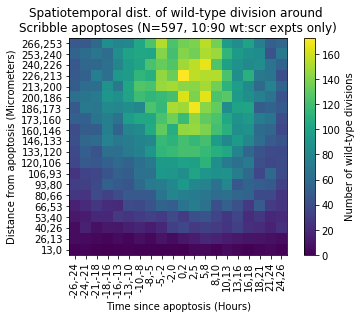

In [158]:
render.plot_cumulative(input_2d_hist = N_events,
                num_bins  = 20,
                radius  = 800,
                t_range = 800,  
                title = 'Spatiotemporal dist. of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Number of wild-type divisions', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True)

Plot saved at  /home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types/Spatiotemporal dist. of probability of wild-type division around 
Scribble apoptoses (N=597, 10:90 wt:scr expts only).pdf


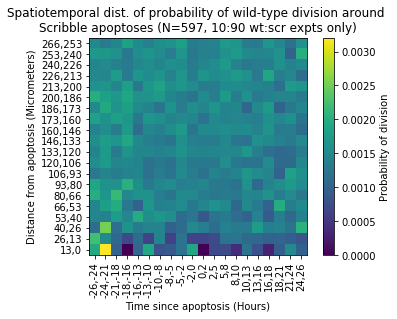

In [159]:
render.plot_cumulative(input_2d_hist = N_events/N_cells,
                num_bins  = 20,
                radius  = 800,
                t_range = 800, 
                title = 'Spatiotemporal dist. of probability of wild-type division around \nScribble apoptoses (N={}, 10:90 wt:scr expts only)'.format(N),
                label = '', 
                cb_label = 'Probability of division', 
                save_path = '/home/nathan/data/kraken/h2b/giulia/radial_analysis_output/cumulative_plots/800,20/scr_apop_wt_div/expt_types',
                SI = True)

Write a function to do a time evolving plot that iteratively adds single cell heat maps according to the apoptosis time?